In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Printing/output settings

In [2]:
pd.set_option('display.max_colwidth', None)

# Explanatory Data Analysis

### Load data

We will load only positives reviews (rating > 3) from the database.

In [3]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect("initial_data/database.sqlite"))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

Each podcast has multiple categories so we will concatenate them 
into a single string and will handle them as a single category for now.

In [4]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()

In [5]:
# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

### Removing duplicates reviews
Users might review a podcast more than once. We keep only the latest review.

In [6]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 59619 duplicates ~ 0.033% of total reviews


### Removing reviews with podcast_id not in podcasts table
There are reviews that their podcast id is not in the podcast table so we do not have any info about them.

In [7]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 21579 reviews ~ 0.012% of total reviews


### Keeping only authors with more than N reviews

In [ ]:
# # show number of unique authors per n, print diff percentage from initial and plot the results
# all_authors = reviews["author_id"].unique().shape[0]
# authors_n = {3:None, 4:None, 5:None, 6:None, 7:None, 8:None, 9:None, 10:None}
# for n in authors_n.keys():
#     authors_n[n] = reviews.groupby('author_id').filter(lambda x: len(x) >= n)['author_id'].unique().shape[0]
#     print(f'For n: {n} kept {authors_n[n]} authors ~ {round(authors_n[n]/all_authors,3)}% of total authors')

# plt.bar(authors_n.keys(), authors_n.values())
# plt.xlabel('n')
# plt.ylabel('number of authors')
# plt.title('Number of authors kept for different n')
# plt.show()

In [8]:
# Keep only authors with at least K reviews
K = 5
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)

In [9]:
# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

Unique authors: 18551
Unique reviews: 156646


### Creating the final dataset

In [10]:
# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)

In [14]:
print(reviews_w_podcast_w_category.columns)
print(reviews_w_podcast_w_category.head(10))
# clean memory
del  reviews
del podcast_w_category


Index(['author_id', 'podcast_id', 'p_title', 'category', 'rating',
       'created_at'],
      dtype='object')
              author_id                        podcast_id  \
37962   FFF559CD2875885  f5f405721f37e3311a58f07da974c756   
70977   FFF559CD2875885  d90bfe6641533109ad8becc21057319e   
144040  FFF559CD2875885  accd597caede356b5b920ed044847925   
13437   FFF559CD2875885  bf5bf76d5b6ffbf9a31bba4480383b7f   
6264    FFF559CD2875885  b1a3eb2aa8e82ecbe9c91ed9a963c362   
78906   FFF171657D896FA  d8d94c2dd8822e1f541909b6161a84c9   
3068    FFF171657D896FA  c82f5735d514b7fedf335b306d5e57d0   
36287   FFF171657D896FA  a41abf97ee745a60fd5b99dedfe92a30   
110912  FFF171657D896FA  aa0fd01b9eca64b92072ad02a698debd   
135821  FFF171657D896FA  e1f8877bd4511924864147cc22797254   

                                         p_title  \
37962                                 Pink Shade   
70977                     True Crime & Cocktails   
144040                       Marriage and Murder   
13437    

In [ ]:
### We have 3 ideas for the clustering:
#  1. Cluster based on the average rating of the categories
#       We will represent each author as a vector of size 108 (at the total number of most frequent categories)
#       Each element of the vector will be the average rating of the author for the category
#       We will use KMeans to cluster the authors

#  2. Cluster based on the K most recent reviews
#       We will represent each author as a vector of size K, where each element is a podcast title
#       We will use KModes to cluster the authors
#  3. Cluster based on the K most recent reviews

#       We will represent each author as a vector of size K, where each element is a podcast category
#       We will use KModes to cluster the authors


### Idea 1

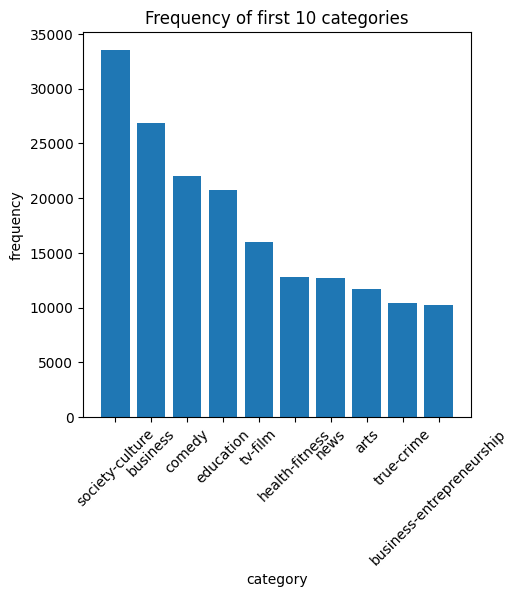

In [42]:
# Compute frequency of each category
category_freq = reviews_w_podcast_w_category['category'].str.split('#').explode().value_counts().to_dict()
# plot first 10 categories
plt.figure(figsize=(5,5))
plt.bar(list(category_freq.keys())[:10], list(category_freq.values())[:10])
plt.xticks(rotation=45)
plt.xlabel('category')
plt.ylabel('frequency')
plt.title('Frequency of first 10 categories')
plt.show()

In [53]:
# Idea 1 
# Each author is a datapoint with 109 features (categories) 0-1

# Create datapoint for each author with index as author_id
datapoints = reviews_w_podcast_w_category[['author_id', 'category','created_at','rating']].copy()
datapoints = datapoints.sort_values(by=['author_id', 'created_at'], ascending=False)
# Replace category with most frequent category of the combined categories which podcast has
datapoints['category'] = datapoints['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
authors = datapoints['author_id'].unique()
print(datapoints['category'].unique().shape[0])



import time
start_time = time.time()

matrix_all_categories = pd.DataFrame(index=authors, columns=datapoints['category'].unique())
matrix_all_categories = matrix_all_categories.fillna(0)
matrix_all_categories_freq = pd.DataFrame(index=authors, columns=datapoints['category'].unique())
matrix_all_categories_freq = matrix_all_categories_freq.fillna(0)


for i, row in enumerate(datapoints.itertuples()):
    i = i + 1
    matrix_all_categories.loc[row.author_id, row.category] = row.rating
    matrix_all_categories_freq.loc[row.author_id, row.category] += 1

    if i % 100 == 0:
        print(f'{i} reviews processed ~ {round(i/datapoints.shape[0],3)}% of total reviews ~ {round((time.time() - start_time)/60,3)} minutes elapsed ~ {round((time.time() - start_time)/60/(i/datapoints.shape[0]),3)} minutes remaining')

# normalize the matrix
matrix_all_categories = matrix_all_categories.div(matrix_all_categories_freq, axis=0)




108
100 reviews processed ~ 0.001% of total reviews ~ 0.051 minutes elapsed ~ 80.077 minutes remaining
200 reviews processed ~ 0.001% of total reviews ~ 0.052 minutes elapsed ~ 40.574 minutes remaining
300 reviews processed ~ 0.002% of total reviews ~ 0.052 minutes elapsed ~ 27.406 minutes remaining
400 reviews processed ~ 0.003% of total reviews ~ 0.053 minutes elapsed ~ 20.809 minutes remaining
500 reviews processed ~ 0.003% of total reviews ~ 0.054 minutes elapsed ~ 16.856 minutes remaining
600 reviews processed ~ 0.004% of total reviews ~ 0.054 minutes elapsed ~ 14.221 minutes remaining
700 reviews processed ~ 0.004% of total reviews ~ 0.055 minutes elapsed ~ 12.365 minutes remaining
800 reviews processed ~ 0.005% of total reviews ~ 0.056 minutes elapsed ~ 10.963 minutes remaining
900 reviews processed ~ 0.006% of total reviews ~ 0.057 minutes elapsed ~ 9.869 minutes remaining
1000 reviews processed ~ 0.006% of total reviews ~ 0.057 minutes elapsed ~ 8.984 minutes remaining
1100 re

In [67]:
matrix_all_categories = matrix_all_categories.fillna(0)

k: 2, iterations: 22
k: 3, iterations: 17
k: 4, iterations: 22
k: 5, iterations: 29
k: 6, iterations: 21
k: 7, iterations: 14
k: 8, iterations: 35
k: 9, iterations: 26
k: 10, iterations: 29
k: 11, iterations: 35
k: 12, iterations: 28
k: 13, iterations: 21
k: 14, iterations: 42
k: 15, iterations: 27
k: 16, iterations: 25
k: 17, iterations: 48
k: 18, iterations: 29
k: 19, iterations: 37
k: 20, iterations: 28
k: 21, iterations: 30
k: 22, iterations: 48
k: 23, iterations: 35
k: 24, iterations: 28
k: 30, iterations: 26
k: 35, iterations: 30
k: 40, iterations: 29
k: 50, iterations: 42
k: 60, iterations: 22


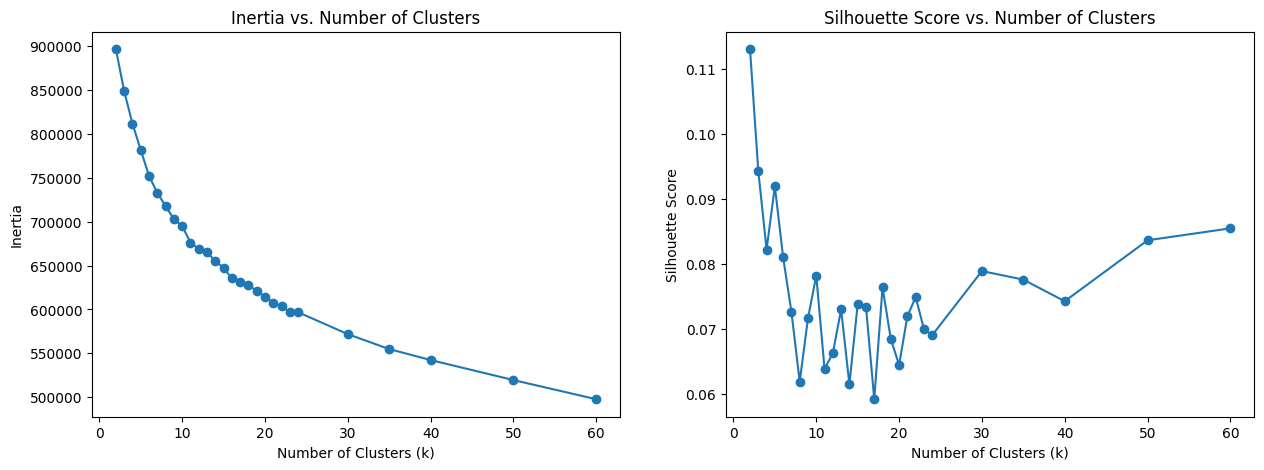

In [74]:
# Clustering of matrix_all_categories

# import the necessary packages
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])
inertias = []
silhouette_scores = []
# loop over K values
for k in K_clusters:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
    # fit the model to the matrix
    kmeans.fit(matrix_all_categories)
    # siluette score
    silhouette_avg = metrics.silhouette_score(matrix_all_categories, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    # get the inertia
    inertias.append(kmeans.inertia_)
    # print the number of iterations required to converge
    print(f'k: {k}, iterations: {kmeans.n_iter_}')

# plot the inertias and silhouette scores for each K value in two separate plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(K_clusters, inertias, '-o')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Inertia vs. Number of Clusters')

ax2.plot(K_clusters, silhouette_scores, '-o')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. Number of Clusters')
plt.show()


In [ ]:
# Assign the cluster labels to the matrix
matrix_all_categories['cluster'] = kmeans.labels_

### Idea 2

In [81]:
# Keep the K most recent reviews for each author
reviews_w_podcast_w_category_k = reviews_w_podcast_w_category.groupby('author_id').head(K)
authors = reviews_w_podcast_w_category_k['author_id'].unique()
total_authors = authors.shape[0]
print(f'Unique authors: {total_authors}')

Unique authors: 18551


In [91]:
# Idea 2
# Each author is a datapoint with K features (podcast titles)
datapoints = reviews_w_podcast_w_category_k[['author_id', 'p_title', 'created_at', 'rating']]
# populate the matrix
matrix_K_titles = pd.DataFrame(index=authors, columns=['title_' + str(i) for i in range(K)])
matrix_K_titles = matrix_K_titles.fillna("empty")
# fill the matrix with the average rating of the author for the podcast title in order
print(matrix_K_titles.shape)
print(authors.shape)
print(K)
for index, author in enumerate (authors):
    index = index + 1
    titles = datapoints[datapoints['author_id'] == author]['p_title'].values
    for i in range(K):
        matrix_K_titles.loc[author, 'title_' + str(i)] = titles[i]
    # keep track of progress
    if index % 3000 == 0:
        print(f'{index} authors processed')

(18551, 5)
(18551,)
5
3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed


(18551, 5)
For K: 2 -> Max iterations: 1  Cost: 92255.0 Time: 0.042 minutes
For K: 3 -> Max iterations: 1  Cost: 92090.0 Time: 0.04 minutes
For K: 4 -> Max iterations: 1  Cost: 91918.0 Time: 0.039 minutes
For K: 5 -> Max iterations: 1  Cost: 91793.0 Time: 0.041 minutes
For K: 6 -> Max iterations: 1  Cost: 91677.0 Time: 0.065 minutes
For K: 7 -> Max iterations: 1  Cost: 91533.0 Time: 0.065 minutes
For K: 8 -> Max iterations: 1  Cost: 91424.0 Time: 0.083 minutes
For K: 9 -> Max iterations: 1  Cost: 91333.0 Time: 0.085 minutes
For K: 10 -> Max iterations: 1  Cost: 91215.0 Time: 0.06 minutes
For K: 11 -> Max iterations: 2  Cost: 91126.0 Time: 0.089 minutes
For K: 12 -> Max iterations: 2  Cost: 91036.0 Time: 0.066 minutes
For K: 13 -> Max iterations: 2  Cost: 91010.0 Time: 0.11 minutes
For K: 14 -> Max iterations: 2  Cost: 90925.0 Time: 0.097 minutes
For K: 15 -> Max iterations: 2  Cost: 90879.0 Time: 0.103 minutes
For K: 16 -> Max iterations: 2  Cost: 90835.0 Time: 0.107 minutes
For K: 17 

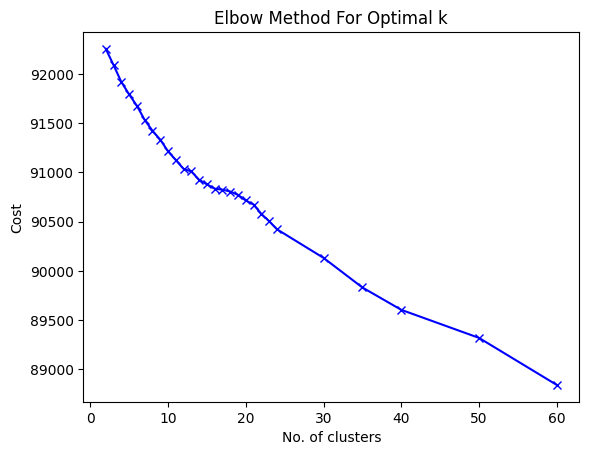

In [96]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_K_titles = matrix_K_titles.astype('str')
print(matrix_K_titles.shape)
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])

# create a list of silhouette scores
cost = []

# loop over K values
import time

for k in K_clusters:
    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = "Cao", verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(matrix_K_titles)
    # get the cost
    cost.append(kmodes.cost_)
    # print max iterations of the algorithm
    end_time = time.time()
    print(f"For K: {k} -> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    #print(f"Centroids: {kmodes.cluster_centroids_}")
# plot the results
plt.plot(K_clusters, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Assign the cluster labels to the matrix
matrix_K_titles['cluster'] = kmodes.labels_

### Idea 3

In [100]:
# Idea 3
# Each author is a datapoint with K features (podcast categories)
datapoints = reviews_w_podcast_w_category_k[['author_id', 'category', 'created_at', 'rating']]
# populate the matrix
matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
matrix_K_categories = matrix_K_categories.fillna("empty")
# fill the matrix with the average rating of the author for the podcast title in order
for index, author in enumerate (authors):
    index = index + 1
    categories = datapoints[datapoints['author_id'] == author]['category'].values
    for i in range(K):
        matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
    if index % 3000 == 0:
        print(f'{index} authors processed')

3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed


(18551, 5)
For K: 2 -> Max iterations: 1  Cost: 86271.0 Time: 0.057 minutes
For K: 3 -> Max iterations: 1  Cost: 84088.0 Time: 0.061 minutes
For K: 4 -> Max iterations: 1  Cost: 82999.0 Time: 0.058 minutes
For K: 5 -> Max iterations: 1  Cost: 82534.0 Time: 0.065 minutes
For K: 6 -> Max iterations: 1  Cost: 82125.0 Time: 0.098 minutes
For K: 7 -> Max iterations: 1  Cost: 81957.0 Time: 0.074 minutes
For K: 8 -> Max iterations: 1  Cost: 81403.0 Time: 0.079 minutes
For K: 9 -> Max iterations: 1  Cost: 81324.0 Time: 0.074 minutes
For K: 10 -> Max iterations: 1  Cost: 81169.0 Time: 0.075 minutes
For K: 11 -> Max iterations: 1  Cost: 80937.0 Time: 0.08 minutes
For K: 12 -> Max iterations: 1  Cost: 80912.0 Time: 0.085 minutes
For K: 13 -> Max iterations: 1  Cost: 80705.0 Time: 0.082 minutes
For K: 14 -> Max iterations: 1  Cost: 80511.0 Time: 0.075 minutes
For K: 15 -> Max iterations: 2  Cost: 79434.0 Time: 0.099 minutes
For K: 16 -> Max iterations: 2  Cost: 78575.0 Time: 0.105 minutes
For K: 1

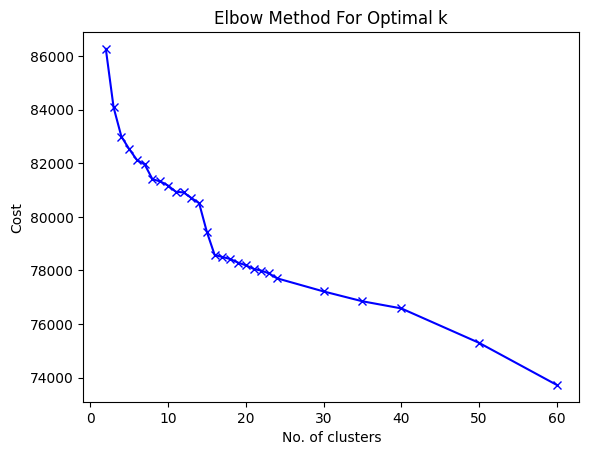

In [101]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_K_categories = matrix_K_categories.astype('str')
print(matrix_K_categories.shape)
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])

# create a list of silhouette scores
cost = []

# loop over K values
import time

for k in K_clusters:
    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = "Cao", verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(matrix_K_categories)
    # get the cost
    cost.append(kmodes.cost_)
    # print max iterations of the algorithm
    end_time = time.time()
    print(f"For K: {k} -> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    #print(f"Centroids: {kmodes.cluster_centroids_}")
# plot the results
plt.plot(K_clusters, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Assign the cluster labels to the matrix
matrix_K_categories['cluster'] = kmodes.labels_

In [ ]:
# Idea 1 results
# get unique authors and their cluster labels
authors_clusters_1 = matrix_all_categories[['cluster']].reset_index().drop_duplicates()
# get the number of authors in each cluster as percentage
authors_clusters_1['count'] = 1
authors_clusters_1_count = authors_clusters_1.groupby('cluster').count().reset_index()
authors_clusters_1['percentage'] = authors_clusters_1.groupby('cluster')['author_id'].transform('count')/authors_clusters_1.shape[0]
authors_clusters_1 = authors_clusters_1.sort_values(by='count', ascending=False)
print(authors_clusters_1)
authors_clusters_1_result = authors_clusters_1[['author_id', 'cluster']]

# Idea 2 results
authors_clusters_2 = matrix_K_titles[['cluster']].reset_index().drop_duplicates()
# get the number of authors in each cluster
authors_clusters_2['count'] = 1
authors_clusters_2 = authors_clusters_2.groupby('cluster').count().reset_index()
authors_clusters_2['percentage'] = authors_clusters_2.groupby('cluster')['author_id'].transform('count')/authors_clusters_2.shape[0]
authors_clusters_2 = authors_clusters_2.sort_values(by='count', ascending=False)
print(authors_clusters_2)
authors_clusters_2_result = authors_clusters_2[['author_id', 'cluster']]

# Idea 3 results
authors_clusters_3 = matrix_K_categories[['cluster']].reset_index().drop_duplicates()
# get the number of authors in each cluster
authors_clusters_3['count'] = 1
authors_clusters_3 = authors_clusters_3.groupby('cluster').count().reset_index()
authors_clusters_3['percentage'] = authors_clusters_3.groupby('cluster')['author_id'].transform('count')/authors_clusters_3.shape[0]
authors_clusters_3 = authors_clusters_3.sort_values(by='count', ascending=False)
print(authors_clusters_3)
# get only author_id and cluster
authors_clusters_3_result = authors_clusters_3[['author_id', 'cluster']]